## Imports

In [2]:
import os
import joblib
import sys
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
# Завантаження даних
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
origin_dim = x_train.shape[1]

# Нормалізація
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# reshape to flat
x_train_flat = x_train.reshape((len(x_train), -1))
x_test_flat = x_test.reshape((len(x_test), -1))

x_train_flat.shape

(60000, 784)

## Pipeline

In [4]:
# AE
lat_dim_ae = 12
inputs = tf.keras.layers.Input(shape=(784,))
encoded = tf.keras.layers.Dense(128, activation='relu')(inputs)
encoded = tf.keras.layers.Dense(lat_dim_ae, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(128, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(decoded)

autoencoder = tf.keras.Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

start_time = time.time()
autoencoder.fit(x_train_flat, x_train_flat, epochs=10)
AE_train_time = time.time() - start_time

x_train_ae = autoencoder.predict(x_train_flat)
x_test_ae = autoencoder.predict(x_test_flat)
x_train_ae.shape



Epoch 1/10

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0344
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0223
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0197
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0185
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0178
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0174
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0170
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0163
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0158
Epoch 10/10
313/313 [==============================] - 0s 907us/step


(60000, 784)

In [21]:
# SVD
lat_dim_svd = 12
svd = TruncatedSVD(n_components=lat_dim_svd*lat_dim_svd)

start_time = time.time()
svd.fit(x_train_ae)
# svd.fit(x_train_flat)
svd_train_time = time.time() - start_time

x_train_svd = svd.transform(x_train_ae)
x_test_svd = svd.transform(x_test_ae)
# x_train_svd = svd.transform(x_train_flat)
# x_test_svd = svd.transform(x_test_flat)
x_train_svd.shape

(60000, 144)

In [22]:
x_train_reduced = x_train_svd
x_test_reduced = x_test_svd

In [23]:
print("AE train time:", AE_train_time)
print("SVD train time:", svd_train_time)

AE train time: 34.090847969055176
SVD train time: 1.7305171489715576


## evaluation on MLPClassifier

### MLP model

In [5]:
def make_mlp_model(x_train, y_train):
    mlp_model = MLPClassifier(solver='lbfgs')
    mlp_model.fit(x_train, y_train)
    return mlp_model

### Other Functions

In [27]:
def print_model_size(model_to_save):
    file_path =  'my_model.joblib'
    joblib.dump(model_to_save, file_path)
    
    file_size_bytes = os.path.getsize(file_path)
    file_size_kb = file_size_bytes / 1024
    print(f"Розмір файлу-моделі на диску: {file_size_kb:.2f} KB")
    if os.path.isfile(file_path):
        os.remove(file_path)

In [26]:
def my_score(mlp_model1, x_test):
    start_time = time.time()
    y_pred = mlp_model1.predict(x_test)
    print(f"Час затрачений для передбачення всіх x_test({len(x_test)}) - {round(time.time() - start_time, 2)} сек")

    size_in_bytes = sys.getsizeof(mlp_model1)
    print(f"Розмір моделі в оперативній пам'яті: {size_in_bytes} байт")
    print_model_size(mlp_model1)
    
    print("classification report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Матриця помилок')
    plt.xlabel('Передбачений клас')
    plt.ylabel('Справжній клас')
    plt.show()

In [25]:
def performance_evaluation(x_train, x_test):
    start_time = time.time()
    mlp_model = make_mlp_model(x_train, y_train)
    print(f"Час навчання mlp - {round(time.time() - start_time, 2)}")
    my_score(mlp_model, x_test)

### Performance evaluation - original data

Час навчання mlp - 28.337270259857178
Час затрачений для передбачення всіх x_test(10000) - 0.03600001335144043 сек
Розмір моделі в оперативній пам'яті: 56 байт
Розмір файлу на диску: 625.42 KB
classification report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.97      1032
           3       0.97      0.98      0.97      1010
           4       0.98      0.97      0.98       982
           5       0.98      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.96      0.97      0.97       974
           9       0.96      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



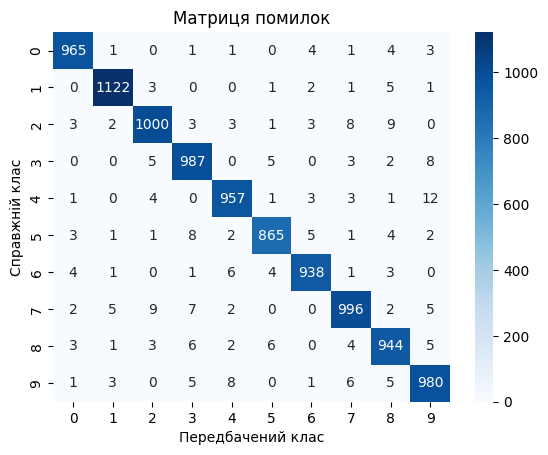

In [17]:
performance_evaluation(x_train_flat,x_test_flat)

### Performance evaluation - reduced data - only AE

c:\Program Files\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Час навчання mlp - 37.46381592750549
Час затрачений для передбачення всіх x_test(10000) - 0.044126272201538086 сек
Розмір моделі в оперативній пам'яті: 56 байт
Розмір файлу на диску: 625.42 KB
classification report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.96      0.95      0.96      1032
           3       0.93      0.95      0.94      1010
           4       0.95      0.95      0.95       982
           5       0.95      0.95      0.95       892
           6       0.97      0.98      0.98       958
           7       0.95      0.96      0.95      1028
           8       0.94      0.92      0.93       974
           9       0.94      0.92      0.93      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



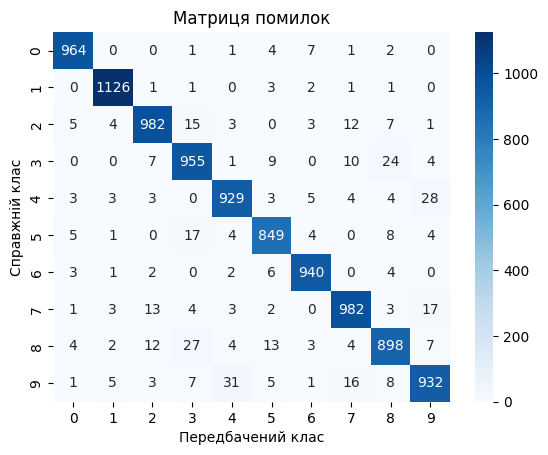

In [19]:
performance_evaluation(x_train_ae,x_test_ae)

### Performance evaluation - reduced data - only SVD

Час навчання mlp - 17.29539179801941
Час затрачений для передбачення всіх x_test(10000) - 0.01251983642578125 сек
Розмір моделі в оперативній пам'яті: 56 байт
Розмір файлу на диску: 125.41 KB
classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.97      0.98      0.98       982
           5       0.99      0.97      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.97      0.98      0.97       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



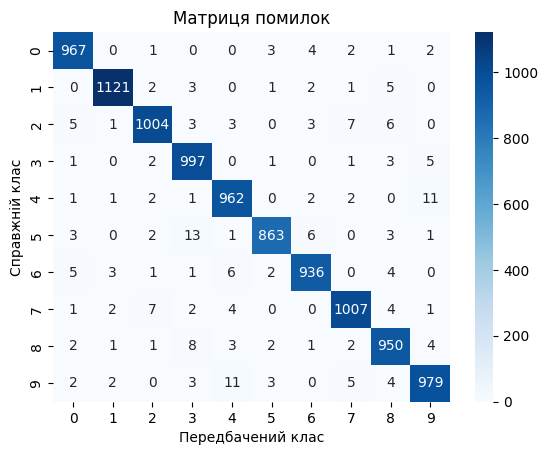

In [20]:
# note: use x train without AE
# performance_evaluation(x_train_svd,x_test_svd)

### Performance evaluation - reduced data

c:\Program Files\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Час навчання mlp - 19.786543369293213
Час затрачений для передбачення всіх x_test(10000) - 0.010999679565429688 сек
Розмір моделі в оперативній пам'яті: 56 байт
Розмір файлу на диску: 125.41 KB
classification report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.95      0.96      1032
           3       0.93      0.94      0.94      1010
           4       0.95      0.95      0.95       982
           5       0.94      0.95      0.94       892
           6       0.97      0.98      0.98       958
           7       0.96      0.96      0.96      1028
           8       0.92      0.92      0.92       974
           9       0.94      0.93      0.93      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



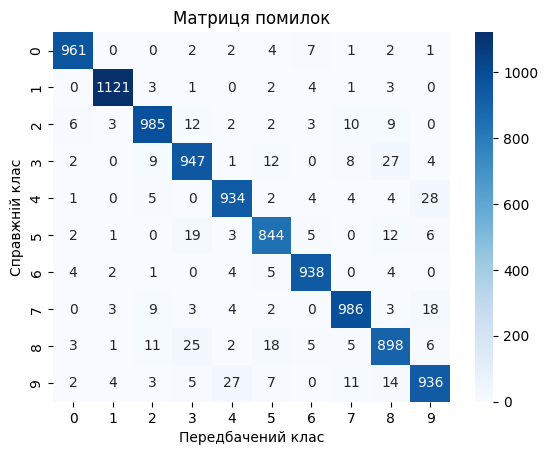

In [24]:
performance_evaluation(x_train_reduced,x_test_reduced)

### print all data size

In [45]:
x1 = sys.getsizeof(x_train)
x2 = sys.getsizeof(x_train_ae)
x3 = sys.getsizeof(x_train_reduced)
print(f"Розмір оригінальних даних       - { x1 } байт")
print(f"Розмір після автоенкодера       - { x2 } байт ({x2/x1})")
print(f"Розмір після автоенкодера + SVD - { x3 } байт ({x3/x2})")

Розмір оригінальних даних       - 188160144 байт
Розмір після автоенкодера       - 188160128 байт (0.9999999149660515)
Розмір після автоенкодера + SVD - 34560128 байт (0.1836740247115478)


# visualisation

In [43]:
x_ae = x_train_ae.reshape(len(x_train_ae), origin_dim, -1)
x_ae.shape

(60000, 28, 28)

In [44]:
X_recovered = svd.inverse_transform(x_train_svd)
x_svd = X_recovered.reshape(len(X_recovered), origin_dim, -1)
x_svd.shape

(60000, 28, 28)

In [45]:
x_svd_lat = x_train_svd.reshape(len(x_train_svd), lat_dim_svd, -1)
x_svd_lat.shape

(60000, 12, 12)

In [28]:
def plot_classes(x,y):
    unique_classes = np.unique(y)
    nrows, ncols = 1, 10
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 5), squeeze=False)

    # Для кожного унікального класу
    for i, digit_class in enumerate(unique_classes):
        row, col = i // ncols, i % ncols
        ax = axes[row][col]
        
        class_indices = np.where(y == digit_class)[0]
        digit_index = class_indices[0]
        digit_data = x[digit_index]
            
        ax.imshow(digit_data, cmap='gray')
        ax.set_title(f"Клас: {digit_class}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

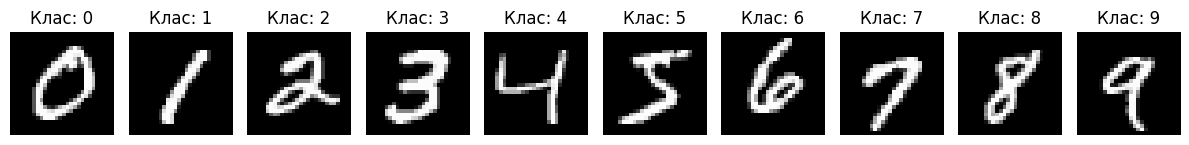

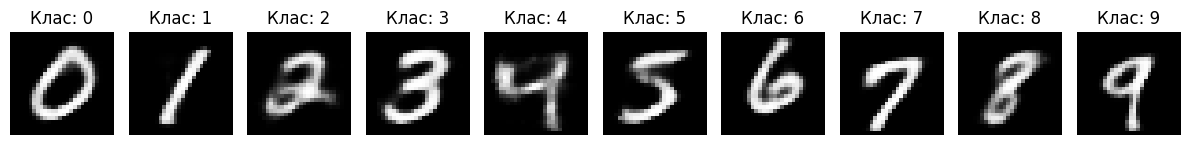

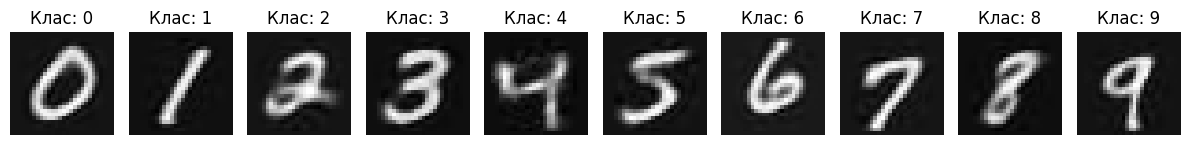

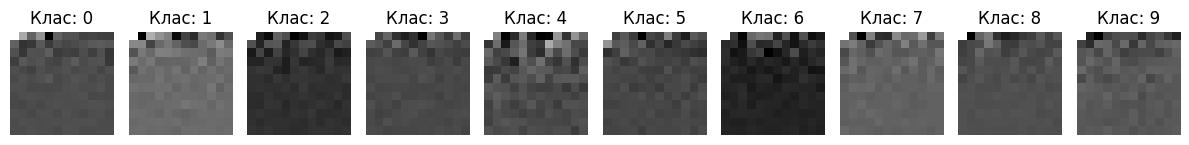

In [46]:
plot_classes(x_train,y_train)
plot_classes(x_ae,y_train)
plot_classes(x_svd,y_train) # after svd inverse
plot_classes(x_svd_lat,y_train) # clean svd

# Grig Search

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Створюємо Pipeline
steps = [
        #  ('AE', LogisticRegression()),
         ('SVD', TruncatedSVD()),
         ('MLP', MLPClassifier())]
pipeline = Pipeline(steps)

# Визначаємо простір пошуку гіперпараметрів для model1 та model2
param_grid = {
    # 'AE__latdimm': [12, 15, 20, 30, 40],
    'SVD__n_components': list(range(10,200,10))
}

# Виконуємо GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='accuracy', return_train_score=True)
grid_search.fit(x_train_flat, y_train)

# Отримуємо масив значень з гіперпараметрами та відповідною точністю
results = pd.DataFrame(grid_search.cv_results_)

c:\Program Files\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Program Files\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Program Files\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Program Files\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Program Files\Python311\Lib\site-packages\sklearn\neural_netw

In [5]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_SVD__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,23.464268,0.172599,0.017599,4.894346e-04,10,{'SVD__n_components': 10},0.930917,0.932083,0.932250,0.926167,...,0.931267,0.002867,19,0.945958,0.946250,0.945396,0.945833,0.942542,0.945196,0.001355
1,34.328611,0.325420,0.018001,9.702201e-07,20,{'SVD__n_components': 20},0.969750,0.968167,0.967000,0.964500,...,0.967383,0.001714,18,0.990000,0.990146,0.991458,0.992021,0.990229,0.990771,0.000814
2,34.902877,0.159568,0.019600,1.742591e-03,30,{'SVD__n_components': 30},0.972500,0.971833,0.972750,0.970167,...,0.971917,0.000925,16,0.999354,0.999521,0.999146,0.999708,0.999604,0.999467,0.000198
3,31.754411,1.131350,0.019164,3.300430e-04,40,{'SVD__n_components': 40},0.975500,0.974417,0.973917,0.970500,...,0.973650,0.001678,8,1.000000,0.999979,1.000000,1.000000,1.000000,0.999996,0.000008
4,24.373397,1.499582,0.021199,1.469899e-03,50,{'SVD__n_components': 50},0.975917,0.974250,0.971333,0.973000,...,0.973583,0.001505,12,1.000000,0.999875,1.000000,1.000000,0.998667,0.999708,0.000523
5,20.811109,1.611590,0.021599,1.019749e-03,60,{'SVD__n_components': 60},0.977083,0.974667,0.973833,0.971333,...,0.974450,0.001890,5,1.000000,0.999521,1.000000,0.999979,1.000000,0.999900,0.000190
6,17.996399,1.214760,0.021200,9.801338e-04,70,{'SVD__n_components': 70},0.976000,0.974917,0.973917,0.972750,...,0.975067,0.001719,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
7,17.814387,0.858464,0.022171,1.549125e-03,80,{'SVD__n_components': 80},0.974833,0.976250,0.972667,0.972833,...,0.974383,0.001410,6,0.999958,1.000000,1.000000,1.000000,1.000000,0.999992,0.000017
8,16.334334,0.620394,0.023401,1.356551e-03,90,{'SVD__n_components': 90},0.975583,0.976333,0.973500,0.972583,...,0.974633,0.001383,4,1.000000,1.000000,1.000000,1.000000,0.999979,0.999996,0.000008
9,16.836587,0.616275,0.026199,3.999000e-04,100,{'SVD__n_components': 100},0.976250,0.976250,0.974250,0.973833,...,0.974700,0.001337,3,1.000000,1.000000,1.000000,1.000000,0.999062,0.999812,0.000375


In [18]:
results2 = results[['param_SVD__n_components', 'mean_test_score', 'rank_test_score', 'mean_fit_time', 'mean_score_time']]
results2

,param_SVD__n_components,mean_test_score,rank_test_score,mean_fit_time,mean_score_time
0,10,0.931267,19,23.464268,0.017599
1,20,0.967383,18,34.328611,0.018001
2,30,0.971917,16,34.902877,0.019600
3,40,0.973650,8,31.754411,0.019164
4,50,0.973583,12,24.373397,0.021199
5,60,0.974450,5,20.811109,0.021599
6,70,0.975067,2,17.996399,0.021200
7,80,0.974383,6,17.814387,0.022171
8,90,0.974633,4,16.334334,0.023401
9,100,0.974700,3,16.836587,0.026199


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


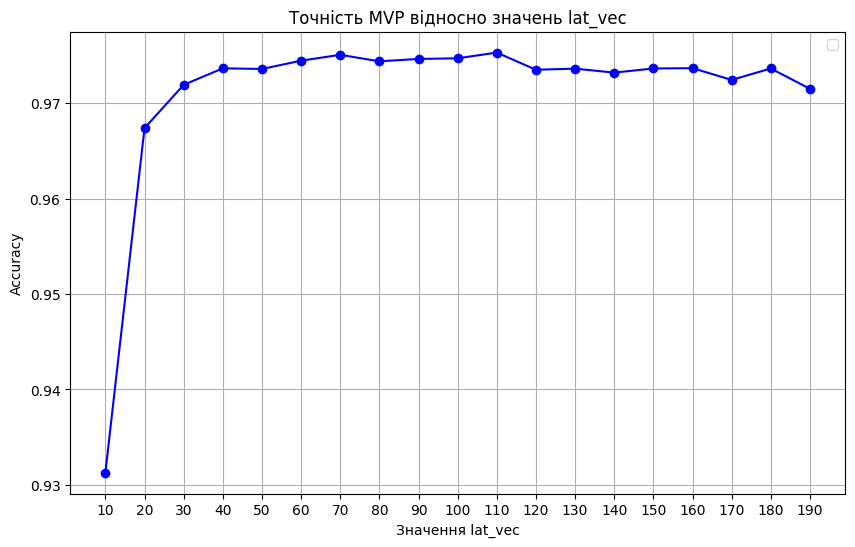

In [19]:
plt.figure(figsize=(10, 6))

plt.plot(results[['param_SVD__n_components']], results[['mean_test_score']], marker='o', color='blue')

plt.xlabel('Значення lat_vec')
plt.ylabel('Accuracy')
plt.title('Точність MVP відносно значень lat_vec')
plt.xticks(results['param_SVD__n_components'].tolist())
plt.grid(True)
plt.legend()

plt.show()

# TODO 
- read: https://www.kaggle.com/code/jonathankristanto/experimenting-with-pca-on-mnist-dataset
- як впливає автоенкодер - не дуже добре
- доп. алгоритими до пайплайну - pass
- різні методи оцінки якості редукції +
    - розмір даних після редукції +
    - модель:
        - час навчання +
        - швидкість відгуку моделі +
        - розмір моделі на диску +
        - розмір моделі в оперативці +

- архітектура AE +
    - + оригінал ae (12lat): 
        - час навчання AE  - 34 
        - час навчання mlp - 37 
        - час передбачення - 0.044 
        - точність         - 0.96
    - + 1 прихований шар: 
        - час навчання AE  - 30 
        - час навчання mlp - 36.2 
        - час передбачення - 0.036 
        - точність         - 0.95
    - + 2 приховані шари: 
        - час навчання AE  - 29 
        - час навчання mlp - 38 
        - час передбачення - 0.044 
        - точність         - 0.96

- gridsearch для пайплайну
    - AE збільшити кількість latt vec +
    - підібрати параметри для SVD, зробити графік (звітність)

- дослідити для яких алгоритмів (дерева рішень, класифікація) ми отримаємо перевагу від редукції

---
дані після SVD захищені (шифрування)

На майбутнє: робота з RGB